In [1]:
from lsmulator import *
from workloads import *
import numpy as np
import matplotlib.pyplot as plt
from figure_grid import *

# LSMulator Demo

The goal of this notebook is to show how simulations of our LSM tree perform under different workload conditions.

In [2]:
def show_queries(wls):
  qs = [[q[0] for q in wl.queries] for wl in wls]
  maxy = max(max(q) for q in qs)
  maxx = len(qs[0])
  with figure_grid(1, len(wls)) as grid:
    for q, wl, ax in zip(qs, wls, grid.each_subplot()):
      plt.title(wl)
      plt.xlim(0, maxx)
      if type(wl) == ZipfWorkload:
        plt.yscale("log")
      else:
        plt.ylim(0, maxy)
      plt.scatter(range(len(q)), q, alpha=0.025)

First let's generate a workload following the Zipf distribution, which was used in the ART paper to evaluate Trie performance. In the Zipf distribution, we'll have a lot of queries for the lowest-valued keys and only a few for higher valued keys. In our LSM tree, we'll treat the first query for a key as an insertion and subsequent queries as reads (though we might make some of them updates later).

In [3]:
zipfs = [ZipfWorkload(zipf_param=1.1),
         ZipfWorkload(zipf_param=1.25),
         ZipfWorkload(zipf_param=1.5)]

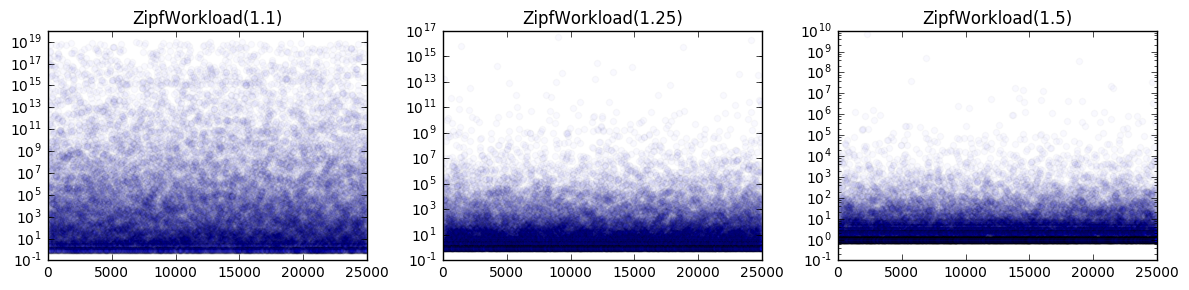

In [4]:
show_queries(zipfs)

We can also have what I'm calling a "Multinomial" workload, where each key (with a fixed number of keys) has a different "popularity," sampled from some distribution at the outset, but which remains constant over time. This is unrealistic, but the base-case (uniform popularity) matches what seem to be the assumptions behind most analyses. 

In [5]:
mults = [MultinomialWorkload(),
         MultinomialWorkload(dist=scipy.stats.gamma(2)),
         MultinomialWorkload(dist=scipy.stats.expon(1))]

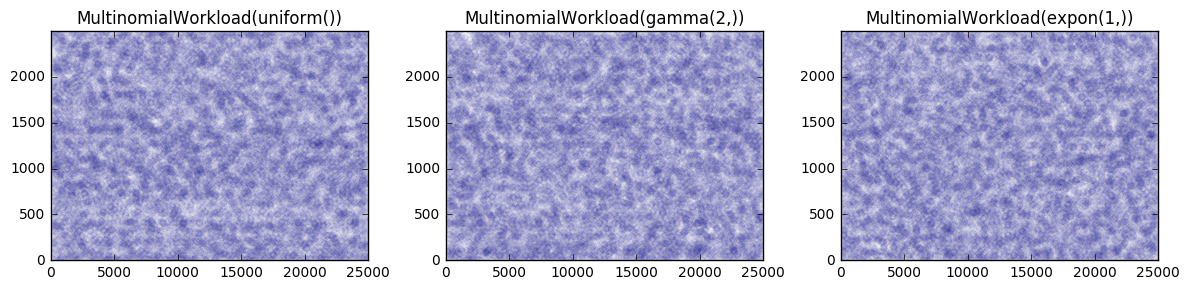

In [6]:
show_queries(mults)

Now let's add our first time-decaying model. This might be a bit overengineered, but the idea is that most of the keys inserted into our LSM tree are only popular for a short period of time (i.e. their popularity decays). We can vary the rate of decay or the rate at which new keys are added (eventually we should simulate write spikes). The idea eventually would be to build a model that is just complex enough to capture the time-dependencies in real-world query distributions and find some way of inferring a decent model, which we can then use to optimize our tree.

In [7]:
timedecs = [DiscoverDecayWorkload(),
            DiscoverDecayWorkload(creates=scipy.stats.poisson(5)),
            DiscoverDecayWorkload(decay_rate=scipy.stats.beta(10, 1)),
            DiscoverDecayWorkload(decay_rate=scipy.stats.beta(1, 1))]

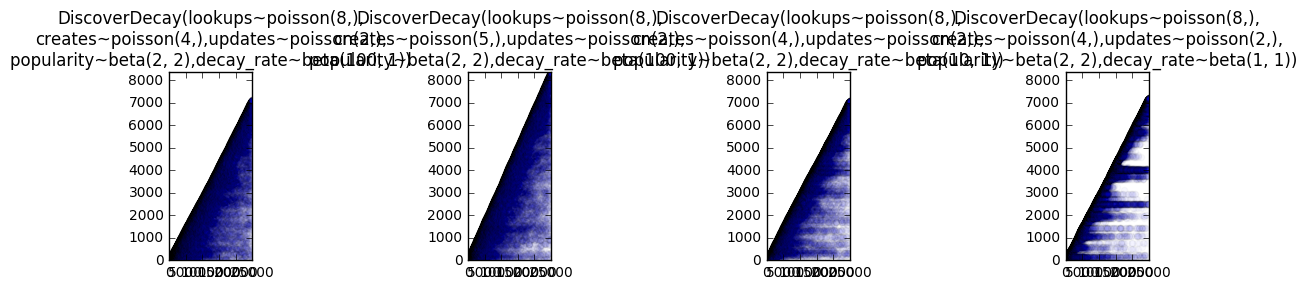

In [8]:
show_queries(timedecs)

We can take our Discover-Decay model further and overlay periodic effects

In [9]:
periods = [PeriodicDecayWorkload(period=100),
           PeriodicDecayWorkload(period=1000),
           PeriodicDecayWorkload(period=1000,cuspiness=10)]

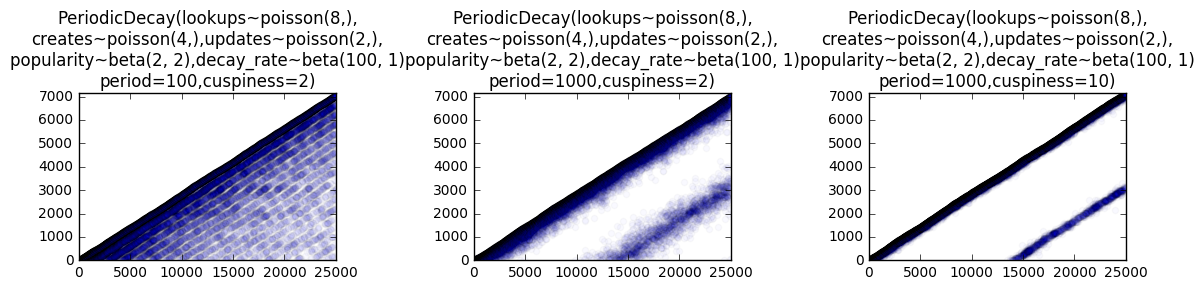

In [10]:
show_queries(periods)

This is starting to get pretty funky.

Finally, let's consider what would happen if we took this to the extreme of periodicity. There, we get the evil round-robin workload, that will thrash our cache:

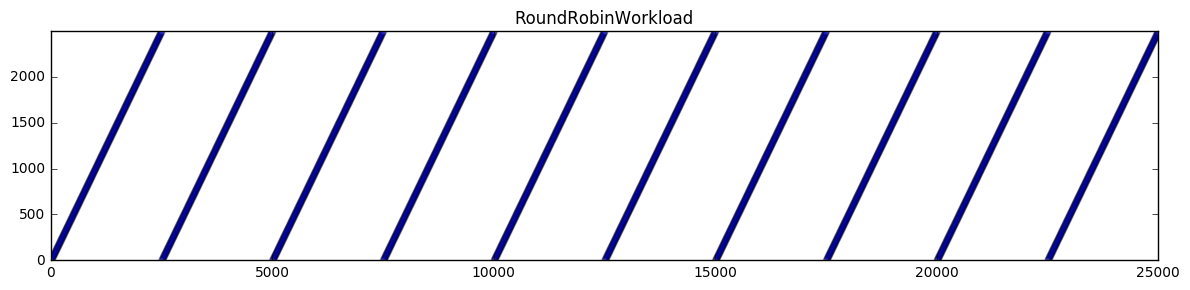

In [11]:
robins = [RoundRobinWorkload()]
show_queries(robins)

Now that we have an intuition for our query distributions, let's see how our LSM tree performs under each.

In [12]:
def plot_tree(lsmtree):
  layers = lsmtree.layers
  cache = lsmtree.cache
  plt.bar(np.arange(len(layers)+1)-0.4, [cache.total_hits()]+[l.total_accesses() for l in layers])
  plt.xticks(range(len(layers)+1),
             ['Cache', 'Mtbl'] + ['L{}'.format(i) for i in range(1,len(layers))])
  plt.ylabel('# queries that access')
  plt.xlabel('LSM tree component')
  
def dictstr(h):
  return ', '.join(['{}={}'.format(k,v) for k,v in h.items()])
  
def plot_workload_trees(wls, title='', gridsize=None, **tree_options):
  trees = [lsmulate(wl.queries, **tree_options) for wl in wls]
  if gridsize is None:
    gridsize = (1, len(wls))
  with figure_grid(*gridsize) as grid:
    if title:
      grid.fig.suptitle('{}\n{}'.format(title, dictstr(tree_options)), y=1.15, fontsize=14)
    for i, ax in enumerate(grid.each_subplot()):
      plt.title(wls[i].__str__())
      plot_tree(trees[i])

Our basic multinomial query distributions are actually pretty similar -- effectively uniform (even though some queries are more popular than others still). We'll need to make these more skewed to make them interesting. One important thing to note is that for the LSM tree options we try below, most of the queries are to the lowest-level layers, because we're effectively sampling randomly, and most of our data is in the lowest layers.

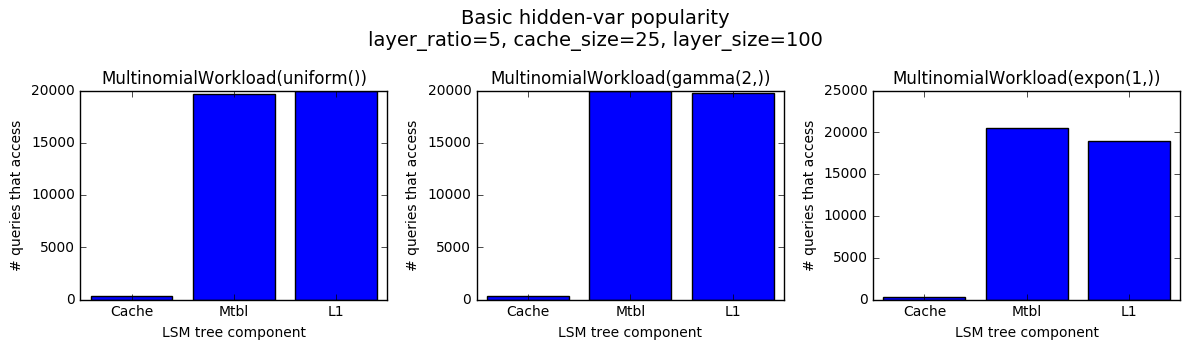

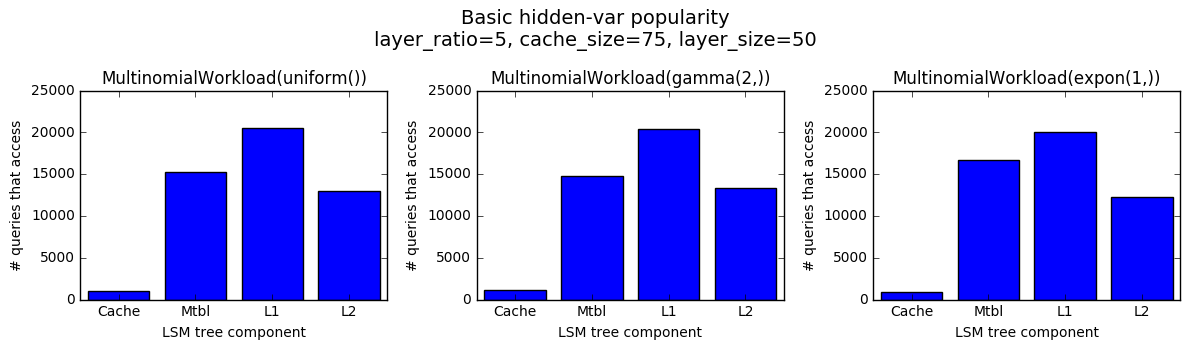

In [13]:
plot_workload_trees(mults, 'Basic hidden-var popularity',
    **{'cache_size': 25, 'layer_size': 100, 'layer_ratio': 5})

plot_workload_trees(mults, 'Basic hidden-var popularity',
    **{'cache_size': 75, 'layer_size': 50, 'layer_ratio': 5})

We see above that increasing the cache size helped us a little bit, but not significantly.

On the Zipf workloads, however, having a big cache helps us a lot, and for the Zipf(1.1) workload (which is the least skewed), increasing the cache size helps us out significantly:

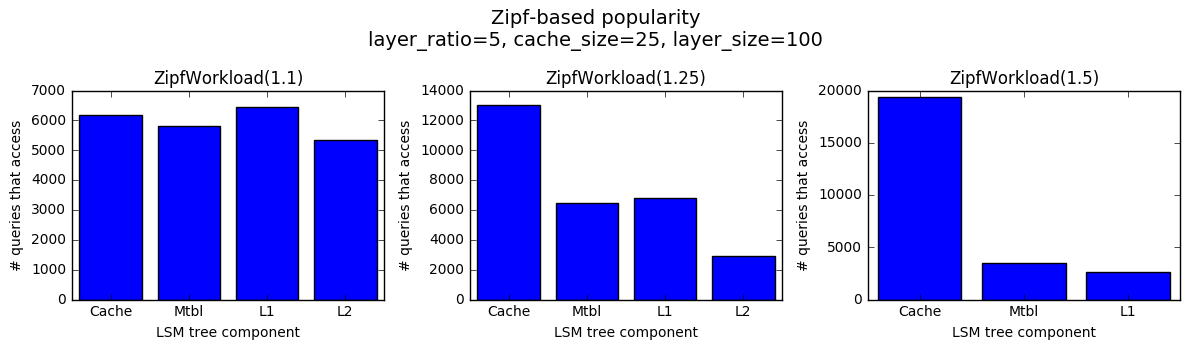

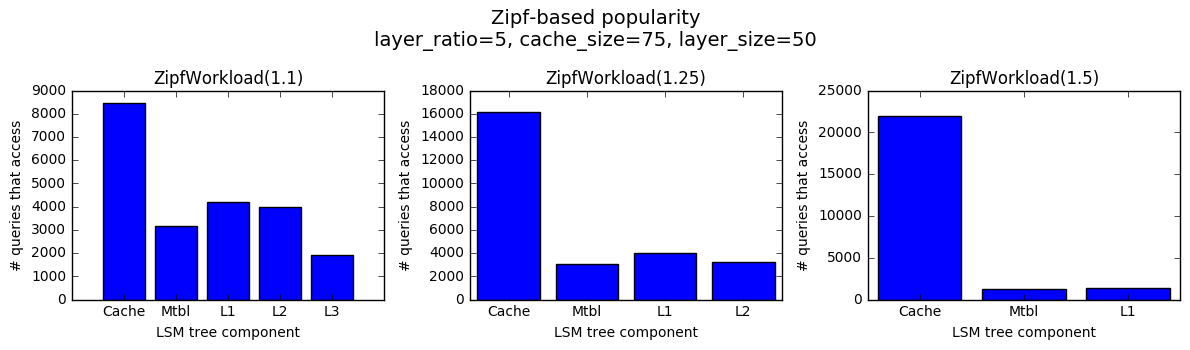

In [14]:
plot_workload_trees(zipfs, 'Zipf-based popularity',
    **{'cache_size': 25, 'layer_size': 100, 'layer_ratio': 5})

plot_workload_trees(zipfs, 'Zipf-based popularity',
    **{'cache_size': 75, 'layer_size': 50, 'layer_ratio': 5})

Now let's start considering some models with temporal dependencies (below):

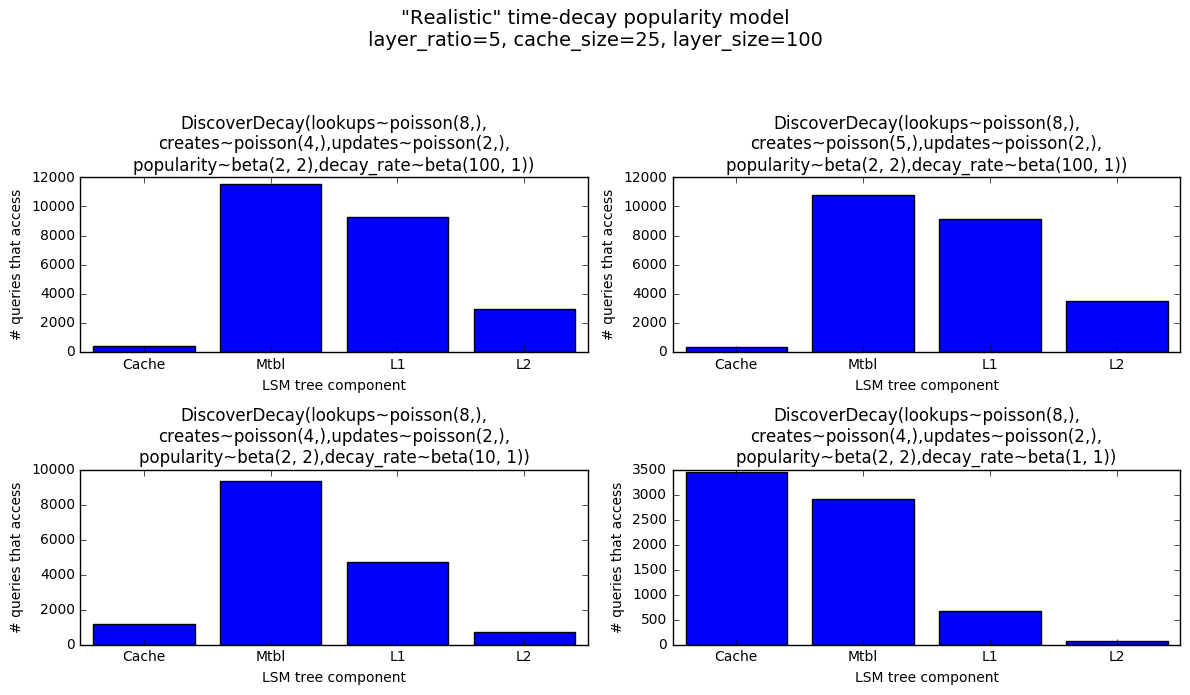

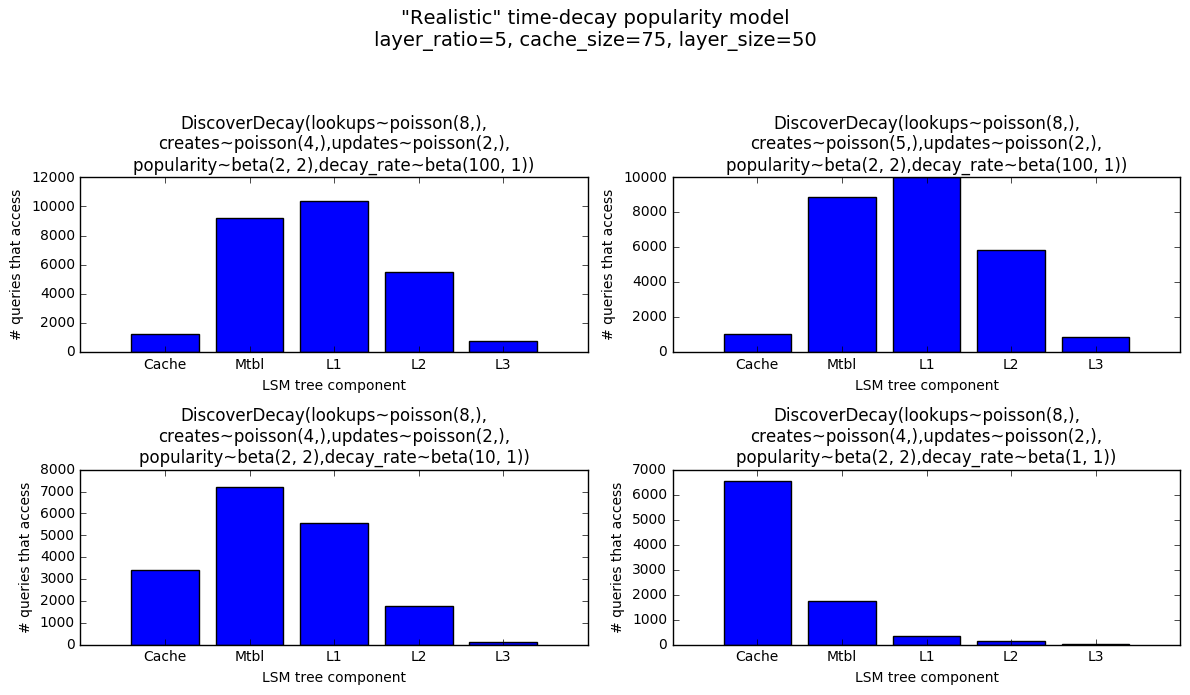

In [15]:
plot_workload_trees(timedecs, '"Realistic" time-decay popularity model', (2,2),
    **{'cache_size': 25, 'layer_size': 100, 'layer_ratio': 5})

plot_workload_trees(timedecs, '"Realistic" time-decay popularity model', (2,2),
    **{'cache_size': 75, 'layer_size': 50, 'layer_ratio': 5})

First, note that our lowest level, even though it contains the most data, often gets queried less often (because data stored there is less likely to be accessed, since it's old). Also, caching is very helpful when recent items are more common, and the memtable actually may be kind of supplanted by the cache (though it's difficult to distinguish the memtable's lack of popularity from its small size without delving into the data further, which we could, but not now).

Finally, let's just confirm the awfulness of round-robin queries:

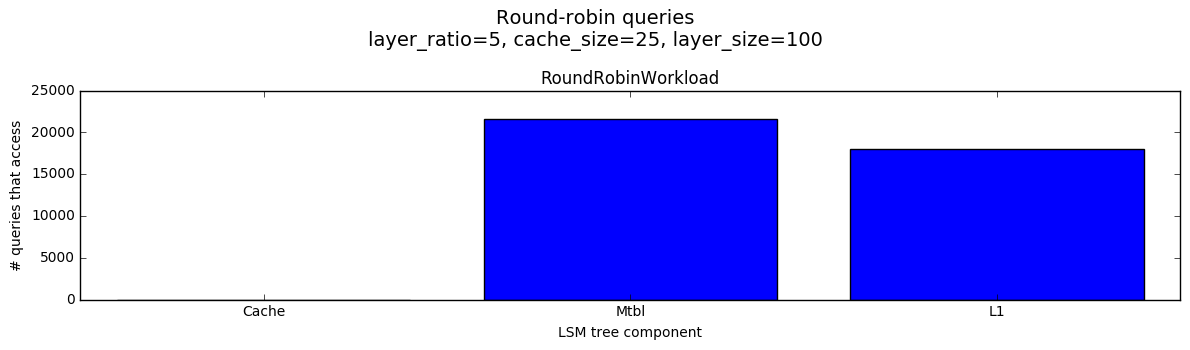

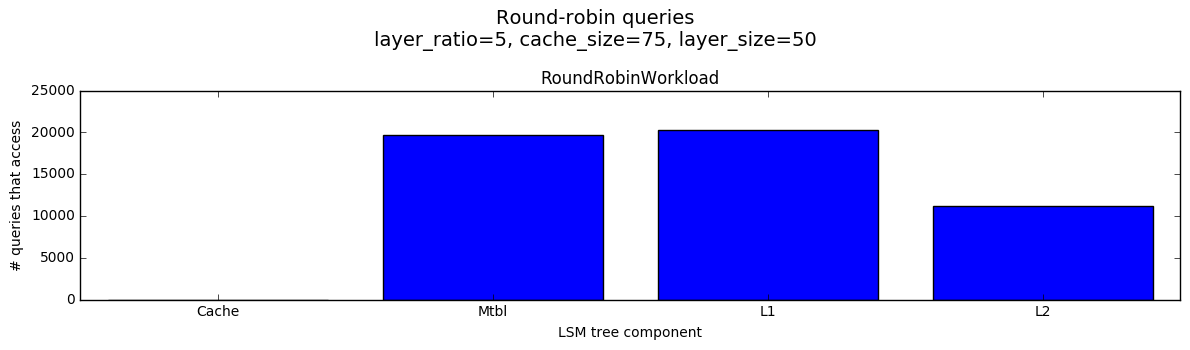

In [16]:
plot_workload_trees(robins, 'Round-robin queries',
    **{'cache_size': 25, 'layer_size': 100, 'layer_ratio': 5})

plot_workload_trees(robins, 'Round-robin queries',
    **{'cache_size': 75, 'layer_size': 50, 'layer_ratio': 5})

The cache is utterly useless, and most of our queries have to go to the lowest levels of our tree.

Hopefully this illustrates how differently LSM trees can behave based on the underlying query distribution, and why optimizing for it is a promising approach!

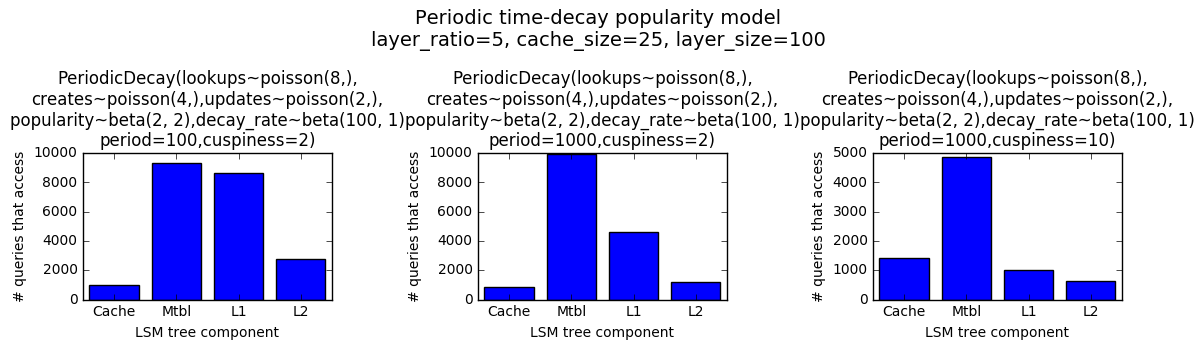

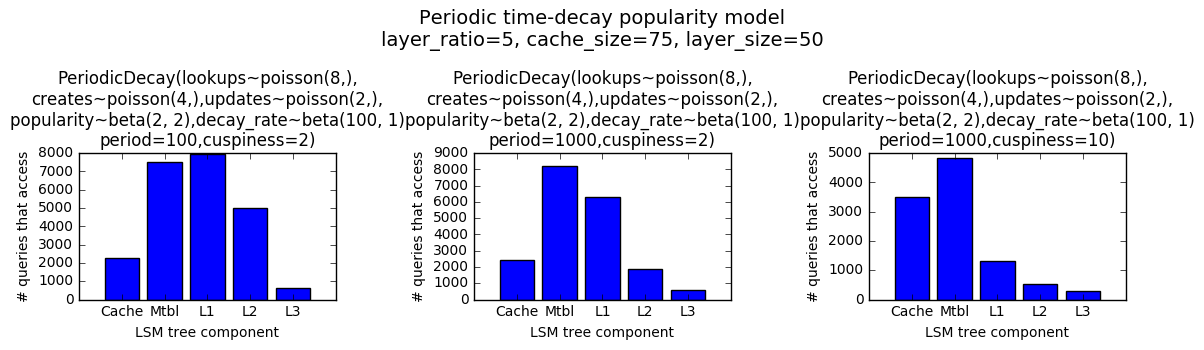

In [19]:
plot_workload_trees(periods, 'Periodic time-decay popularity model', (1,3),
    **{'cache_size': 25, 'layer_size': 100, 'layer_ratio': 5})

plot_workload_trees(periods, 'Periodic time-decay popularity model', (1,3),
    **{'cache_size': 75, 'layer_size': 50, 'layer_ratio': 5})